### Navod:
Na prvom riadku pod importami nastav konstanty (krok pre ticks na x a y osi; koeficient pre vypocet sirky intervalu TRP ktorym sa nasobi std. deviation pre TRP v danom clustri pricom stred intervalu je TRP mean daneho clustra; pocet clustrov).  
Na druhomom riadku nastav cestu k suboru s datami.  
Na tretom riadku vyselektuj riadky potrebne pre vypocet clustrov.  



In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
x_ticks = 20
y_ticks = 5
std_coef = 0.5
clusters_num = 4

In [3]:
#nacitanie dat z xlsx suboru
df_sel = pd.read_excel(r'\\srvdc01\STARMEDIA\Clients\_Analyzy\RG\TCCC\191010-TCCC-podklady do prezy, len spoty, PT-RG.xlsx', 
             sheet_name='raw data')

In [4]:
#vyber nenulovych 'Base brand' a vylucenie TCCC
df_sel = df_sel[(df_sel['Base brand'].notna()) & (df_sel['Názov zadávateľa'] != 'COCA COLA SLOVAKIA S.R.O.') & (df_sel['TCCC selected cats'] == 'TCCC SOFT DRINKS')]

In [5]:
#transformacia dat, ktore vstupuju do vypoctu clustrov, do std. normalneho rozdelenia, t.j. mean=0, standard deviation=1
scaler = StandardScaler().fit(df_sel[['TRP', 'Reach 1+']])
X = scaler.transform(df_sel[['TRP', 'Reach 1+']])

In [6]:
#vypocet clustrov, random_state zaistuje reprodukovatelnost vysledkov, vymazat ak to nie je potrebne
#km = KMeans(n_clusters = clusters_num)
km = KMeans(n_clusters = clusters_num, random_state=100)
result = km.fit_predict(X)

In [7]:
df_sel.insert(loc = 0, column = 'Cluster', value = result)

In [8]:
df_sel_group = df_sel[['Cluster','TRP', 'Reach 1+']].groupby(['Cluster'])
df_sel_group = df_sel_group.describe().sort_values(('TRP','mean'))
df_sel_group

TRP                                                                 \
         count        mean        std    min      25%     50%      75%    max   
Cluster                                                                         
3         12.0   51.341667  23.079249    0.0   41.525   57.35   68.575   76.6   
1        101.0  106.074257  21.526949   71.0   89.500  104.60  121.500  159.4   
0         69.0  185.285507  36.938129  120.4  157.000  181.90  204.600  281.8   
2         24.0  348.670833  57.609695  251.2  320.750  339.65  361.525  491.9   

        Reach 1+                                                           \
           count       mean       std     min       25%     50%       75%   
Cluster                                                                     
3           12.0  26.807000  9.825657   0.000  25.67000  30.875  32.64000   
1          101.0  44.690455  4.177615  36.337  41.75000  44.913  48.21700   
0           69.0  56.867029  3.875370  49.194  54.15400  56.498  59.39200   
2           24.0  69.503542  4.014269  60.846  67.66825  69.357  71.42675   

                 
            max  
Cluster          
3        34.578  
1        53.190  
0        67.764  
2        76.547

In [9]:
#uprava poradie clustrov, od 0 po n
ori_cluster_order = list(df_sel_group.index)
d = dict(zip(ori_cluster_order, range(clusters_num)))
df_sel['Cluster'] = df_sel['Cluster'].replace(d)

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib

<IPython.core.display.Javascript object>


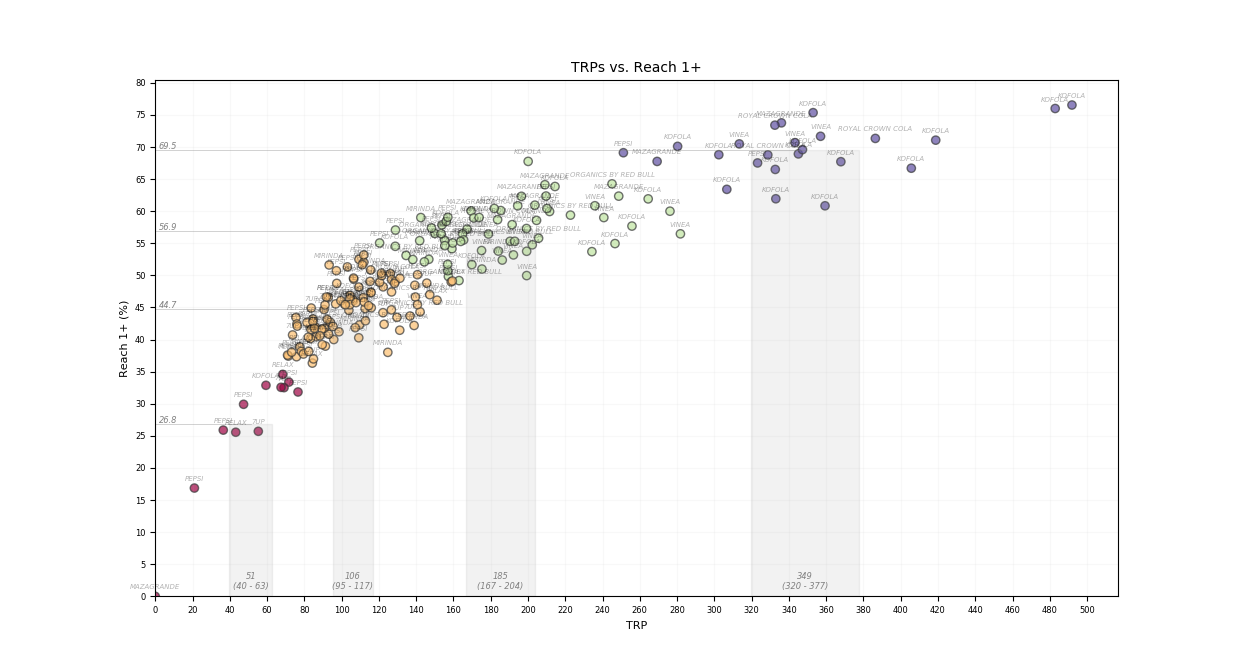

In [11]:
#nastav si konstanty
#nastav si velkost grafu interaktivne, vypni interakciu a skopiruj obrazok cez clipboard alebo uloz ako jpeg do working dir prikazom pod grafom
#alternativne farby: https://medium.com/better-programming/how-to-use-colormaps-with-matplotlib-to-create-colorful-plots-in-python-969b5a892f0c
#cmap = 'Spectral', 'RdPu', 

fig = plt.figure()
sc = plt.scatter(df_sel['TRP'], df_sel['Reach 1+'], c=df_sel['Cluster'], cmap = 'Spectral', alpha=0.7, edgecolors='xkcd:dark gray')
plt.title('TRPs vs. Reach 1+', fontsize=10)
plt.xlabel('TRP', fontsize=8)
plt.ylabel('Reach 1+ (%)', fontsize=8)

plt.grid(b=True, alpha=0.08)
plt.tick_params(labelsize=6)
plt.xticks(range(0,int(x_ticks + x_ticks * (df_sel['TRP'].max() // x_ticks)) + 1, x_ticks))
plt.yticks(range(0,int(y_ticks + y_ticks * (df_sel['Reach 1+'].max() // y_ticks)) + 1, y_ticks))
plt.xlim(left=0)
plt.ylim(bottom=0)

for TRP_mean, TRP_std, Reach_max, Reach_mean in zip(df_sel_group['TRP']['mean'], df_sel_group['TRP']['std'], df_sel_group['Reach 1+']['max'], df_sel_group['Reach 1+']['mean']):
    plt.axvspan(TRP_mean - TRP_std*std_coef, TRP_mean + TRP_std*std_coef, ymax=Reach_mean/plt.ylim()[1], alpha=0.1, color='grey')
    plt.annotate('{:.0f}\n({:.0f} - {:.0f})'.format(TRP_mean, TRP_mean - TRP_std*std_coef, TRP_mean + TRP_std*std_coef),     #this is the text
                 (TRP_mean,0), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 fontsize=6, fontstyle='italic', color='grey')    
    
    plt.axhline(y=Reach_mean, xmin=0, xmax=TRP_mean/plt.xlim()[1], linestyle='-', linewidth=0.5, alpha=0.5, color='grey')
    plt.annotate('{:.1f}'.format(Reach_mean),     #this is the text
                 (0, Reach_mean), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(9,1), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 fontsize=6, fontstyle='italic', color='grey')    

for x, y, b in zip(df_sel['TRP'], df_sel['Reach 1+'], df_sel['Base brand']):
    plt.annotate(b, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 fontsize=5, fontstyle='italic', alpha=0.3)
    


In [13]:
fig.savefig('PowerMap.jpg')